## Diferenças finitas / aproximações numéricas

$$ f'(x) = \lim_{h \to 0} \frac{f(x + h) - f(x)}{h} $$

$$ D_h(x) = \frac{f(x + h) - f(x)}{h} $$

In [15]:
f(x) = exp(x)
fd(x) = exp(x)
D(x,h) = (f(x + h) - f(x)) / h

D (generic function with 1 method)

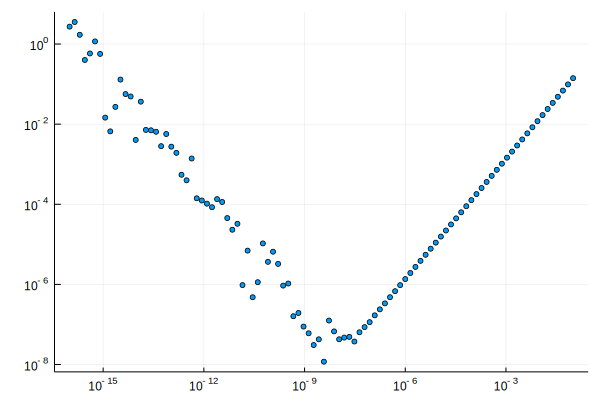

In [40]:
using Plots
gr()

x = 1.0
hs = 10.0 .^ -range(1, 16, length=100)
Es = abs.([ fd(x) - D(x, h) for h in hs])
Es = max.(Es, eps())
scatter(hs, Es, xaxis=:log, yaxis=:log, leg=false, ms=3)

**Cálculo Numérico:**

$$ \begin{aligned}
|f'(x) - D_h(x)| \leq
\frac{2\epsilon_M}{h} \underbrace{\max_{|\xi-x|\leq h} |f'(\xi)|}_{L_1}
+ \frac{h}{2} \underbrace{\max_{|\xi-x|\leq h} |f''(\xi)|}_{L_2}
\end{aligned} $$

Para $f(x) = e^x$, $L_1 = L_2 = e^{x + h}$ 

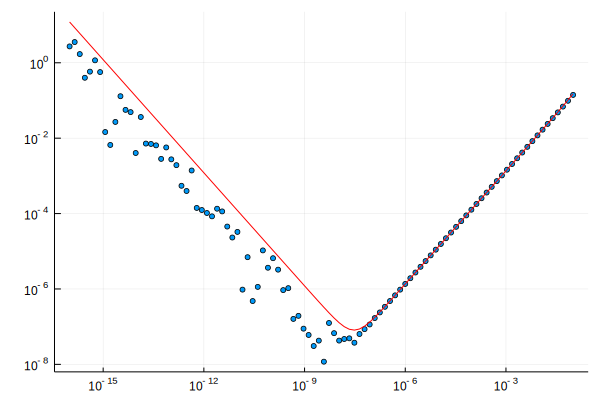

In [48]:
using Plots
gr()

x = 1.0
hs = 10.0 .^ -range(1, 16, length=100)
Es = abs.([ fd(x) - D(x, h) for h in hs])
Es = max.(Es, eps())
limE = 2 * eps() * exp.(x .+ hs) ./ hs + hs .* exp.(x .+ hs) / 2
scatter(hs, Es, xaxis=:log, yaxis=:log, leg=false, ms=3)
plot!(hs, limE, c=:red)

## Números duais

Um número dual é uma extensão dos reais dado por um termo $\epsilon \neq 0$ tal que $\epsilon^2 = 0$. Números duais são escritos como $a + b\epsilon$ onde $a, b \in \mathbb{R}$.

$$ (2 + \epsilon)^2 = 4 + 4\epsilon + \epsilon^2
= 4 + 4\epsilon $$

$$ (a + b\epsilon)^n = a^n + a^{n-1}b\epsilon $$

$$ \begin{aligned}
e^{a + b\epsilon} & = \sum_{k = 0}^{\infty} \frac{(a + b\epsilon)^k}{k!} \\
& = 1 + \sum_{k = 1}^{\infty} \frac{a^k + a^{k-1}b\epsilon}{k!} \\
& = e^a + be^a \epsilon
\end{aligned} $$

$$ \left(\sqrt{a} + \frac{b\epsilon}{2\sqrt{a}}\right)^2
= a + b\epsilon + \left(\frac{b^2\epsilon^2}{4a}\right)
= a + b\epsilon
\qquad \Rightarrow \qquad
\sqrt{a + b\epsilon} = \sqrt{a} + \frac{b\epsilon}{2\sqrt{a}}
$$

$$ \begin{aligned}
f(a + b\epsilon)
& = f(a) + b\epsilon f'(a) + \tfrac{1}{2}b^2\epsilon^2 f''(a) + \dots \\
& = f(a) + \epsilon bf'(a)
\end{aligned} $$

**Portanto, se sabemos calcular a $f$ de um número dual, podemos definir a derivada como o termo dual de $f(a + \epsilon)$.**

In [1]:
struct Dual
    a
    b
end

In [51]:
Dual(x) = Dual(x, 0.0)

function Base.show(io :: IO, d :: Dual)
    show(io, "$(d.a) + $(d.b)ϵ")
end

import Base.+, Base.-, Base.*, Base.^, Base./
function +(d1 :: Dual, d2 :: Dual)
    Dual(d1.a + d2.a, d1.b + d2.b)
end
+(d :: Dual, x) = d + Dual(x)
+(x, d :: Dual) = Dual(x) + d

function -(d1 :: Dual, d2 :: Dual)
    Dual(d1.a - d2.a, d1.b - d2.b)
end
-(d :: Dual, x) = d - Dual(x)
-(x, d :: Dual) = Dual(x) - d

function -(d :: Dual)
    Dual(-d.a, -d.b)
end

function *(d1 :: Dual, d2 :: Dual)
    Dual(d1.a * d2.a, d1.a * d2.b + d2.a * d1.b)
end
*(d :: Dual, x) = Dual(d.a * x, d.b * x)
*(x, d :: Dual) = Dual(d.a * x, d.b * x)

function ^(d :: Dual, p :: Real)
    if p == 0
        return Dual(1, 0)
    else
        return Dual(d.a^p, p * d.a^(p - 1) * d.b)
    end
end

function Base.inv(d :: Dual)
    Dual(inv(d.a), -inv(d.a)^2 * d.b)
end
/(d1 :: Dual, d2 :: Dual) = d1 * inv(d2)
/(x, d :: Dual) = Dual(x) * inv(d)
/(d :: Dual, x) = Dual(d.a / x, d.b / x)

# √(a + bϵ) = √a + ϵ b ½ / √a
function Base.sqrt(d :: Dual)
    Dual(sqrt(d.a), d.b / sqrt(d.a) / 2)
end

# exp(a + bϵ) = exp(a) + ϵ b * exp(a)
function Base.exp(d :: Dual)
    Dual(exp(d.a), d.b * exp(d.a))
end

In [52]:
x = Dual(2, 1)
y = Dual(-1, 3)
x, y

("2 + 1ϵ", "-1 + 3ϵ")

In [53]:
x^2

"4 + 4ϵ"

In [54]:
sqrt(x + 1.3y)

"0.8366600265340756 + 2.9283100928692645ϵ"

In [55]:
(1 / x) * x

"1.0 + 0.0ϵ"

In [56]:
f(x) = exp(x) / sqrt(1 + x^2)

f (generic function with 1 method)

In [57]:
f(Dual(2, 1)).b

1.9826918072122015

In [50]:
(f(2 + 1e-8) - f(2)) / 1e-8 # Comparando com a aproximação numérica

1.9826918329357568

In [10]:
function derivada(f, x)
    f(Dual(x, 1)).b
end

derivada (generic function with 1 method)

In [59]:
derivada(f, 2)

1.9826918072122015

O pacote ForwardDiff faz exatamente isso

In [12]:
using ForwardDiff

In [60]:
ForwardDiff.derivative(f, 2)

1.9826918072122017

## Dificuldade: Esparsidade

$$ f(x) = \sum_{i = 1}^n x_i^2 $$

In [14]:
f(x) = sum(x.^2)
x = ones(30)
ForwardDiff.hessian(f, x)

30×30 Array{Float64,2}:
 2.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  2.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  2.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  2.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  2.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  2.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  2.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 